In [1]:
# -- import packages 
import pandas as pd 

import requests
import json
import datetime
import time

In [4]:
# -- define function: this function loops through graph calls to get Uniswap data \
# ----- note this function can be improved by passing the chain_data dict as a variable - more generalizable across protocols

def getTokenDayData_Uniswap(start_dt, end_dt = None, chains = []):
  #  ==> input:  start and end dates (in datetime)
  # <== output:  pandas dataframe of daily uniswap financial data. Not ordered by date (use groupby on the result)
  
  # --- define end date as today if none provided 
  if end_dt == None: 
    end_dt = datetime.datetime.now()  

  # --- define graph urls (you just have to go find these)
  chain_data = {'balancer_v2_ethereum': {'chain': 'Ethereum', 'version': 'V2', 'protocol': 'Balancer', 'url_plug': 'balancer-v2-ethereum'}, 'bancor_v3_ethereum': {'chain': 'Ethereum', 'version': 'V3', 'protocol': 'Bancor', 'url_plug': 'bancor-v3-ethereum'}, 'platypus_finance_avalanche': {'chain': 'Avalanche', 'version': 'V1', 'protocol': 'Platypus', 'url_plug': 'platypus-finance-avalanche'}, 'curve_finance_ethereum': {'chain': 'Ethereum', 'version': 'V1', 'protocol': 'Curve', 'url_plug': 'curve-finance-ethereum'}, 'saddle_finance_ethereum': {'chain': 'Ethereum', 'version': 'V1', 'protocol': 'Saddle', 'url_plug': 'saddle-finance-ethereum'}, 'sushiswap_avalanche': {'chain': 'Avalanche', 'version': 'V1', 'protocol': 'Sushiswap', 'url_plug': 'sushiswap-avalanche'}, 'sushiswap_ethereum': {'chain': 'Ethereum', 'version': 'V1', 'protocol': 'Sushiswap', 'url_plug': 'sushiswap-ethereum'}, 'uniswap_v3_polygon': {'chain': 'Polygon', 'version': 'V3', 'protocol': 'Uniswap', 'url_plug': 'uniswap-v3-polygon'}}    

  # --- loop through chains. Initialize temp data store first (this is temp list to store daily dictionay results)
  chain_data_list = []

  for chain, chain_details in chain_data.items(): 
    if chain in chains or len(chains) == 0: 
      # -- initialize query date
      query_dt = start_dt 

      # -- loop graph query calls until we get past the end date 
      while query_dt <= end_dt: 

        # --- get timestamp as int for the query date
        timestamp = int(datetime.datetime.timestamp( query_dt ))

        # --- define query (visit the commented urls in chain_data dictionary above to get queries) - note this is a simple query
        query_temp = f"""<financialsDailySnapshots(first: 1000, orderDirection: asc, orderBy: timestamp, where:<timestamp_gte: {timestamp}>)<
                              timestamp
                              totalValueLockedUSD
                              dailyVolumeUSD
                              dailyTotalRevenueUSD
                            >
                          >
                          """
        # --- insert brackets to finalize query format (brakets break the f string format used above)
        query_ = query_temp.replace("<", "{")
        query = query_.replace(">", "}")

        # --- call the graph endpoint
        graph_resp = requests.post( chain_details['url'] , json={'query': query})
        graph_list = json.loads(graph_resp.text)['data']['financialsDailySnapshots'] # note - u may want to do some error handling before this

        # --- unpack data response and format into our pandas dataframe layout
        for item in graph_list: 
          # ---- convert timestamp to datetime object - easier to format 
          temp_dt = datetime.datetime.fromtimestamp(int(item['timestamp']))

          data_formatted = {
            'date': temp_dt.strftime("%Y-%m-%d"), 
            'timestamp': item['timestamp'], 
            'chain': chain_details['chain'],
            'protocol': 'Uniswap', 
            'protocol_version': chain_details['version'],
            'dailyVolumeUSD': round(float(item['dailyVolumeUSD']),3), 
            'dailyTVL': round(float(item['totalValueLockedUSD']),3), 
            'dailyFees': round(float(item['dailyTotalRevenueUSD']),3)
          }

          chain_data_list.append(data_formatted)
      
        # --- set last date + 1 as the new query_dt. This will pagenate and start the loop over 
        last_dt = datetime.datetime.fromtimestamp(int(graph_list[-1]['timestamp']))
        query_dt = last_dt + datetime.timedelta(days=1) # - note this should break the while loop if > end date

  # --- create dataframe for export
  result_df = pd.DataFrame(chain_data_list)
  result_df['date'] = pd.to_datetime(result_df['date'])
  result_df.set_index('date', inplace=True)
  
  return result_df


In [ ]:
# - execute function 
start_dt = datetime.datetime.strptime('2022-01-01', '%Y-%m-%d')
chains = ['Avalanche']

uni_df = getTokenDayData_Uniswap(start_dt, chains = chains)

KeyError: ignored

In [ ]:
# -- see the result 
uni_df

,timestamp,chain,protocol,protocol_version,dailyVolumeUSD,dailyTVL,dailyFees
date,,,,,,,
2022-01-01,1641081591,Ethereum,Uniswap,V3,1.032079e+09,4.545115e+45,2022357.189
2022-01-02,1641167990,Ethereum,Uniswap,V3,1.028874e+09,4.545115e+45,2069780.727
2022-01-03,1641254379,Ethereum,Uniswap,V3,1.225005e+09,4.545115e+45,2560522.076
2022-01-04,1641340797,Ethereum,Uniswap,V3,1.560450e+09,4.545115e+45,2757491.738
2022-01-05,1641427193,Ethereum,Uniswap,V3,2.104650e+09,4.545115e+45,4046664.414
...,...,...,...,...,...,...,...
2022-07-07,1657238391,Optimism,Uniswap,V3,2.060646e+05,7.697477e+06,356.872
2022-07-08,1657324776,Optimism,Uniswap,V3,2.081557e+05,7.700060e+06,434.204
2022-07-09,1657411191,Optimism,Uniswap,V3,1.982242e+05,7.804265e+06,239.585


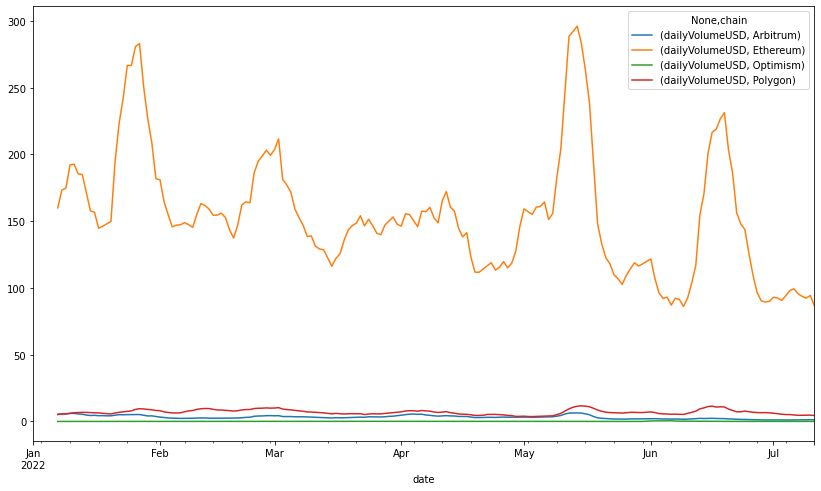

In [ ]:
# -- organize dataframe to plot volume by chain (if this looks confusing - please ask questions > need to learn groupby imo)
uni_plot_df = uni_df.groupby(['date', 'chain'])['dailyVolumeUSD'].sum().to_frame().unstack(level=1) 

# -- simple 7d MA line plot in millions 
(uni_plot_df.rolling(7).mean() / 10000000).plot(figsize = (14,8))